<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Importe libraries and functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import itertools
from IPython.display import Image
import re
import warnings
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
def safe_list_parse(df, column):
    """
    Fix a column where lists are stored as strings.
    Handles both comma-separated and space-separated formats.

    Args:
        df: pandas DataFrame
        column: str, name of the column to fix

    Returns:
        df with the specified column parsed into lists of floats
    """
    df[column] = (
        df[column]
        .astype(str)
        .str.strip('[]')
        .apply(lambda s: [float(x) for x in re.split(r'[,\s]+', s.strip()) if x])
    )
    return df

warnings.filterwarnings("ignore")

In [2]:
# @title Figure 3A (Top & Middle)
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%203A%20(partial).png?raw=true', width=1000)

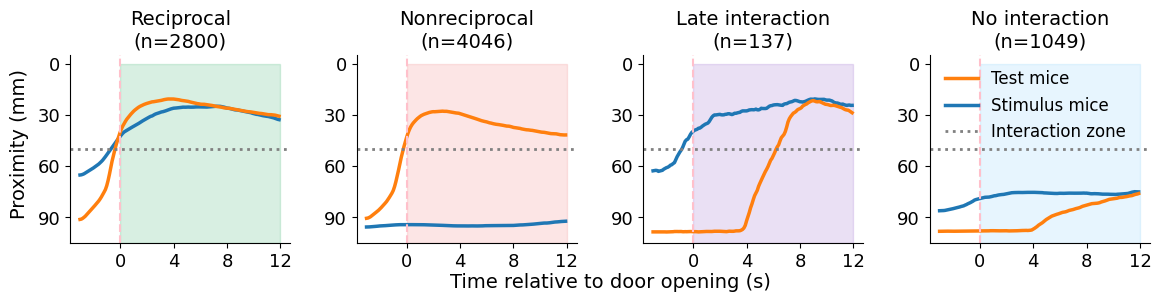

In [3]:
# @title Figure 3A (Bottom)
event_df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure3.csv")

# Example: shared time axis
time_window = np.round(np.arange(-3, 12, 0.1), 2)
event_df = safe_list_parse(event_df, 'event_vector')
event_df = safe_list_parse(event_df, 'time_window')

# Custom colors
light_colors = ["#3CB371", "#F08080", "#9966CC", "#87CEFA"]  # Matching cluster order
clustertitles = ['Reciprocal', 'Nonreciprocal', 'Late interaction', 'No interaction']

# Start figure
fig = plt.figure(figsize=(12, 9))  # Wider to maintain panel size
gs_middle = GridSpec(2, 4, figure=fig, left=0.05, right=0.95, top=0.98, bottom=0.5, hspace=0.3, wspace=0.3)

ax_line_list = []

for cluster_num in range(4):
    ax = fig.add_subplot(gs_middle[1, cluster_num], sharex=ax_line_list[0] if ax_line_list else None, sharey=ax_line_list[0] if ax_line_list else None)

    # Extract proximity data
    cluster_events_prox1 = []
    cluster_events_prox2 = []

    for _, row_data in event_df[event_df['cluster'] == cluster_num].iterrows():
        cluster_events_prox1.append(row_data["event_vector"][:len(row_data["time_window"])] if "time_window" in row_data else [])
        cluster_events_prox2.append(row_data["event_vector"][len(row_data["time_window"]):] if "time_window" in row_data else [])

    cluster_events_prox1 = np.array(cluster_events_prox1)
    cluster_events_prox2 = np.array(cluster_events_prox2)

    if len(cluster_events_prox1) > 0 and len(cluster_events_prox2) > 0:
        avg_prox1 = np.mean(cluster_events_prox1, axis=0)
        avg_prox2 = np.mean(cluster_events_prox2, axis=0)
        ax.plot(time_window, avg_prox1, label="Stimulus mice", lw=2.5)
        ax.plot(time_window, avg_prox2, label="Test mice", lw=2.5)

    # Reference lines and background
    ax.axvline(x=0, color='pink', linestyle='--')
    ax.axhline(y=50, color='grey', linestyle=':', lw=2, label="Interaction zone")
    ax.add_patch(plt.Rectangle((0, 0), 12, 105, color=light_colors[cluster_num], alpha=0.2))

    ax.set_ylim([105, -5])
    ax.set_title(f'{clustertitles[cluster_num]}\n(n={len(cluster_events_prox1)})', fontsize=14)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    ax_line_list.append(ax)

# Global axis labels
fig.text(0.5, 0.45, "Time relative to door opening (s)", ha='center', fontsize=14)
fig.text(0, 0.61, "Proximity (mm)", va='center', rotation='vertical', fontsize=14)

# Legend on last panel only
handles, labels = ax_line_list[-1].get_legend_handles_labels()
order = [1, 0, 2]  # Test, Stimulus, Interaction zone
ax_line_list[-1].legend(
    [handles[i] for i in order],
    [labels[i] for i in order],
    frameon=False,
    loc='upper left',
    fontsize=12
)

plt.tight_layout(rect=[0.05, 0.15, 0.95, 0.95])
plt.show()



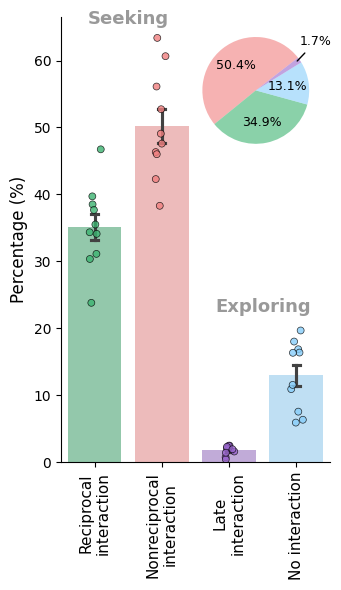

In [2]:
# @title Figure 3B
event_df = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure3.csv")

# Settings
piechartcomponent = 'interaction'
desired_order = ['Reciprocal interaction', 'Nonreciprocal interaction', 'Late interaction', 'No interaction']

# Define colors
light_colors_str = {
    "Late interaction": "#9966CC",
    "Reciprocal interaction": "#3CB371",
    "No interaction": "#87CEFA",
    "Nonreciprocal interaction": "#F08080",
    "Unclassified": 'silver'
}
interaction_color_map = {k: light_colors_str[k] for k in event_df[piechartcomponent].unique()}

# Calculate general percentages
general_interaction_counts = event_df[piechartcomponent].value_counts()
general_interaction_percentages = general_interaction_counts / general_interaction_counts.sum() * 100
general_labels = general_interaction_percentages.index.tolist()
wrapped_labels = [textwrap.fill(label, width=15) for label in general_labels]
colors = [interaction_color_map[label] for label in general_labels]

# Group by mouse
individual_data = event_df.groupby(['device_number', piechartcomponent]).size().unstack(fill_value=0)
individual_data = individual_data.div(individual_data.sum(axis=1), axis=0) * 100  # Convert to percentages

# Reshape for seaborn
interaction_reshaped = individual_data.stack().reset_index()
interaction_reshaped.columns = ['device_number', 'interaction', 'percentage']

# Plot
fig, ax = plt.subplots(figsize=(3.5, 6))

# Bar plot
sns.barplot(
    data=interaction_reshaped,
    x='interaction',
    y='percentage',
    capsize=0.1,
    order=desired_order,
    errorbar='se',
    palette=[light_colors_str[i] for i in desired_order],
    alpha=0.6,
    ax=ax
)

# Overlay individual points
sns.stripplot(
    data=interaction_reshaped,
    x='interaction',
    y='percentage',
    jitter=True,
    order=desired_order,
    alpha=0.8,
    edgecolor='k',
    linewidth=0.5,
    zorder=2,
    palette=[light_colors_str[i] for i in desired_order],
    ax=ax
)

# Cosmetic adjustments
sns.despine(top=True, right=True)
ax.set_xticklabels([textwrap.fill(label, width=15) for label in desired_order], rotation=90, fontsize=11)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_xlabel('')
ax.legend().set_visible(False)

# Add "Seeking" and "Exploring" labels manually (optional, adjust position as needed)
ax.text(0.5, 65.5, "Seeking", fontsize=13, color="gray", ha="center", fontweight="bold", alpha=0.8)
ax.text(2.5, 22.5, "Exploring", fontsize=13, color="gray", ha="center", fontweight="bold", alpha=0.8)

# Inset pie chart
inset_ax = inset_axes(ax, width="50%", height="30%", loc='upper right')

# --- PIE CHART WITH OUTSIDE LABEL FOR SMALL SLICE ---
wedges, texts, autotexts = inset_ax.pie(
    general_interaction_percentages, 
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%" if pct > 1 else "",  # only show >1% inside
    startangle=37.8,
    textprops={'fontsize': 9, 'ha': 'center', 'va': 'center'},
    wedgeprops={'alpha': 0.6},
)

# Get the label (string) of the smallest slice
target_label = general_interaction_percentages.idxmin()

# Find the integer index of that label in the current pie ordering
target_idx = list(general_interaction_percentages.index).index(target_label)

# Compute midpoint angle of that slice
theta = (wedges[target_idx].theta2 + wedges[target_idx].theta1) / 2
x = np.cos(np.deg2rad(theta))
y = np.sin(np.deg2rad(theta))

# Remove default inside label
autotexts[target_idx].set_text("")

# Annotate outside
inset_ax.annotate(
    f"{general_interaction_percentages[target_label]:.1f}%",
    xy=(0.9 * x, 0.9 * y), 
    xytext=(x, y * 1.6),   # shift label right of arrow
    arrowprops=dict(arrowstyle="-", lw=1),
    ha="left", va="center", fontsize=9
)

plt.tight_layout()
plt.show()
